# Assignment 2: Imaging Pipeline

MIDS W281: Computer Vision

## Recommended Libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from glob import glob

## Part 1: Demosaicing

![Bayer Pattern](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_2/bayer_pattern.png)

### Overview
In this exercise you will convert a raw sensor image into a full color image using demosaicing. Digital sensors record color images through a Bayer mosaic (above), where each pixel records only one of the three color colors (RGB). A software interpolation is then needed to reconstruct all three colors at each pixel.

**HINT: There are different Bayer mosaic patterns than the one shown above, so you should look into them if you want the correct setup for Part 1**

### Description:
We will provide you with some raw images, represented as grayscale images (red, green, and blue pixels are all on the same channel of the image). Your task is to write some python code to demosaic and generate a full three-channel RGB image. You're encouraged to debug your code using the image `signs-small.png` because it is not very large and exhibits some interesting challenges of demosaicing. Note that you may need to convert images between `UINT8` and `float32` data types for computation and visualization.

For simplicity we will ignore the pixels at the boundary of the image, specifically the first and last two rows and columns don't need to be reconstructed. This will allow you to focus on the general case and not worry about whether neighboring values are unavailable. It's actually not uncommon for cameras and software to return a slightly-cropped image for similar reasons. Therefore, for an image of size NxN, you will return a cropped image of size (N-2)x(N-2)x3.  

1. Write a python function that takes as input a raw image and offset and returns a single-channel 2-D image corresponding to the interpolated green channel. The offset encodes whether either the top-left pixel or its right neighbor is the first green pixel. In our Figure 1 example, the second pixel is green, so offset=1.  

2. Write another python function for generating the red and blue channels. This function takes a raw image and two offsets: one for row offset and one for column offset, and returns a single-channel image. The row/column offset for the red channel is (0,0) and for the blue channel (1,1) for the Figure 1 example, but that might not be the case for the signs images (see hint). Note that the interpolation for the red/blue channel will be different than the green channel because the recorded pixels are sparser. For interpolated pixels that have two direct neighbors that are known (left-right or up-down), simply take the linear average between the two values. For the remaining case, average the four diagonal pixels. You can ignore the first and last two rows or columns to make sure that you have all the neighbors you need. Similar to the green-channel, interpolate the values when they are missing and copy the values when they are available.  

3. Using the above two functions, create a full three-channel, RGB image. You might observe some checkerboard artifacts around strong edges. This is expected from our naive interpolation approach.

### Deliverables:
- Python code for interpolation of green channel and red/blue channel
- Full-three channel RGB image for `signs.png` (**THE BIG ONE, NOT THE SMALL ONE**)

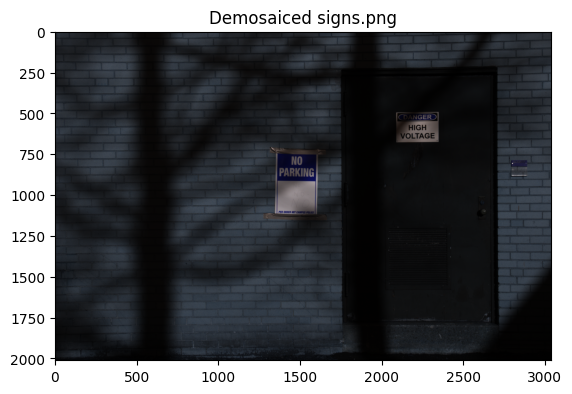

In [19]:
def interpolate_green(raw_img, offset_value):
    H, W = raw_img.shape
    green_interp = np.zeros_like(raw_img, dtype=np.float32)

    # Loop over the inner region for interpolation
    for r in range(1, H - 1):
        for c in range(1, W - 1):
            # Check if current pixel is green
            is_green_pixel = (r % 2 == 0 and c % 2 == offset_value) or \
                             (r % 2 == 1 and c % 2 != offset_value)

            if is_green_pixel:
                green_interp[r, c] = raw_img[r, c]
            else: # Not green, interpolate from 4 orthogonal G neighbors
                green_interp[r, c] = (raw_img[r - 1, c] + raw_img[r + 1, c] +
                                       raw_img[r, c - 1] + raw_img[r, c + 1]) / 4

    # Copy border pixels from the raw image
    green_interp[0, :] = raw_img[0, :]
    green_interp[H-1, :] = raw_img[H-1, :]
    green_interp[:, 0] = raw_img[:, 0]
    green_interp[:, W-1] = raw_img[:, W-1]

    return green_interp

def interpolate_redblue(raw_img, offset_pair):
    H, W = raw_img.shape
    color_interp = np.zeros_like(raw_img, dtype=np.float32)

    target_r_parity, target_c_parity = offset_pair

    # Loop over the inner region for interpolation
    for r in range(1, H - 1):
        for c in range(1, W - 1):
            is_target_color_pixel = (r % 2 == target_r_parity and c % 2 == target_c_parity)
            is_green_pixel = (r % 2 == 0 and c % 2 == 1) or (r % 2 == 1 and c % 2 == 0)

            if is_target_color_pixel:
                color_interp[r, c] = raw_img[r, c]
            elif is_green_pixel: # Interpolate from 2 direct neighbors of target color
                if (r % 2 == target_r_parity): # Green pixel has same row parity as target color
                    # Means horizontal neighbors of target color are present
                    color_interp[r, c] = (raw_img[r, c - 1] + raw_img[r, c + 1]) / 2
                else: # Green pixel has same column parity as target color
                    # Means vertical neighbors of target color are present
                    color_interp[r, c] = (raw_img[r - 1, c] + raw_img[r + 1, c]) / 2
            else: # Pixel is other
                # Interpolate from 4 diagonal neighbors of target color
                color_interp[r, c] = (raw_img[r - 1, c - 1] + raw_img[r - 1, c + 1] +
                                       raw_img[r + 1, c - 1] + raw_img[r + 1, c + 1]) / 4


    color_interp[0, :] = raw_img[0, :]
    color_interp[H-1, :] = raw_img[H-1, :]
    color_interp[:, 0] = raw_img[:, 0]
    color_interp[:, W-1] = raw_img[:, W-1]

    return color_interp


test_img = plt.imread('./signs-small.png')
raw_img = plt.imread('./signs.png')
img_for_demosaic = raw_img.copy().astype(np.float32)

green_offset = 1
blue_offset = (1,1)
red_offset = (0,0)

green_img = interpolate_green(img_for_demosaic, green_offset)
blue_img = interpolate_redblue(img_for_demosaic, blue_offset)
red_img = interpolate_redblue(img_for_demosaic, red_offset)

color_img_full = np.dstack((red_img, green_img, blue_img))


cropped_color_img = color_img_full[1:-1, 1:-1, :]

plt.imshow(cropped_color_img)
plt.title('Demosaiced signs.png')
plt.show()

## Part 2: Denoising

![Denoising Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_2/denoising.png)

### Overview
Random noise is a problem that often arises in cameras specially in extremely low light conditions, and its presence can seriously degrade the quality of a digital image. To remedy the situation, an average of multiple images, captured very close in time, can be used to improve the quality final image. Because the camera may move while recording mulitple images, we will need to align the images before averaging and denoising. We will implement this alignment + denoising algorithm.

### Description:
We provide 18 images captured in a low light setting. One of the images is shown above.

Each image is slightly mis-aligned from the previous image in the sequence. Our goal is to align each of the images in the sequence to the first image and then average the aligned images to reduce the noise (which tends to be independent across images). Note that you may need to convert images between `UINT8` and `float32` data types for computation and visualization.

1. Write a python function that takes as input two images and returns the horizontal and vertical offset that best aligns the two images. Ignore the difference for all the pixels less than or equal to a `maxOffset` away from the edges. Use a brute force approach that tries every possible integer translation and evaluates the quality of a match using the squared error norm (the sum of the squared pixel differences). You can set the `maxOffset` to 15 pixels.  
2. Align each image to the first image and denoise by averaging all of the aligned images.

**HINT: sweeping through all of the offsets means more than just going right and down**

### Deliverables:

- Python code to align noisy images
- Aligned and de-noised average image

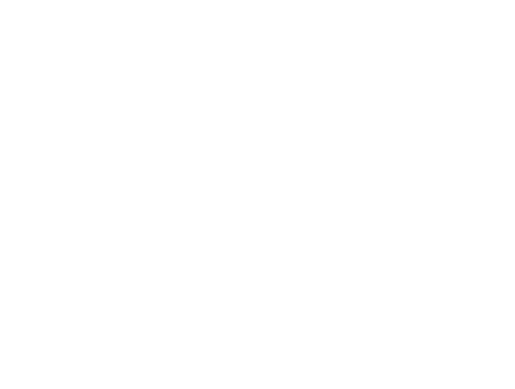

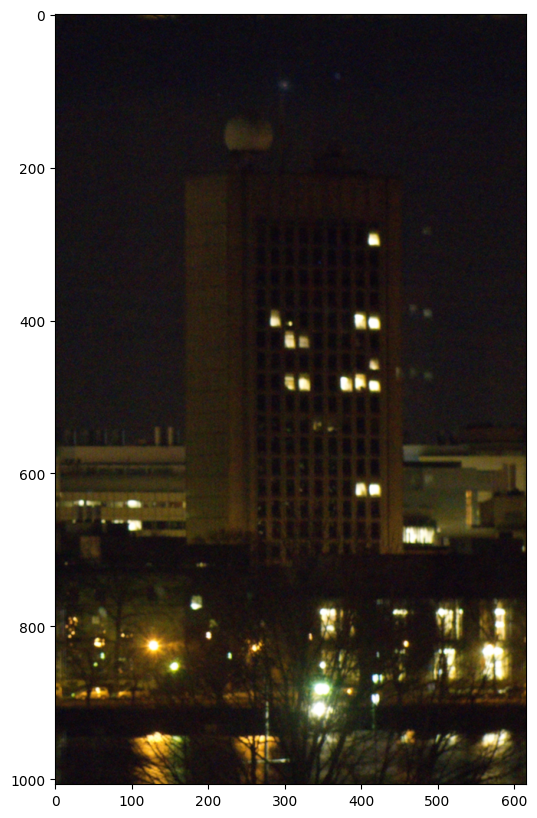

In [7]:
# load images
img_list = sorted(glob('./noise-small-*.png'))
img_ref = plt.imread(img_list[0]).astype(np.float32)

# TODO: use a for-loop to load remaining images and check data types

def align_imgs(img1, img2, maxOffset):
    best_error = float('inf')
    best_offset = (0, 0)
# TODO: use nested for-loops to compute the error for every possible
    # combination of x and y offsets, up to the maxOffset in each dimension
    # The function np.roll may be helpful for shifting the images relative to each other
    # For each offset, compute the squared error norm

    # Define the central region to compare, ignoring borders of size maxOffset
    # Ensure region is valid
    if img1.shape[0] <= 2 * maxOffset or img1.shape[1] <= 2 * maxOffset:
        # Fallback to comparing full images if cropping would result in empty/invalid region
        y_start, y_end = 0, img1.shape[0]
        x_start, x_end = 0, img1.shape[1]
    else:
        y_start, y_end = maxOffset, img1.shape[0] - maxOffset
        x_start, x_end = maxOffset, img1.shape[1] - maxOffset

    for dy in range(-maxOffset, maxOffset + 1):
        for dx in range(-maxOffset, maxOffset + 1):
            # Shift img2 by (dx, dy)
            shifted_img2 = np.roll(np.roll(img2, dy, axis=0), dx, axis=1)

            # Extract the central region for comparison
            cropped_img1 = img1[y_start:y_end, x_start:x_end]
            cropped_shifted_img2 = shifted_img2[y_start:y_end, x_start:x_end]

            # Compute the squared error norm
            # Only compute error if cropped regions are not empty
            if cropped_img1.size > 0 and cropped_shifted_img2.size > 0:
                current_error = np.sum((cropped_img1 - cropped_shifted_img2)**2)
            else:
                # If regions are empty due to cropping, this offset is likely invalid for comparison
                current_error = float('inf')

            if current_error < best_error:
                best_error = current_error
                best_offset = (dy, dx) # corresponds to (row_offset, col_offset)

    return best_offset, best_error

def combine_imgs(img_list, offset_list):
      # TODO: for each image, shift it by the corresponding offset from align_imgs
    # Compute the mean across all offset images
    # Note that you do not need to make an array containing all images
    # It is computationally cheaper to add the weighted pixel values to a running sum image
    # Initialize composite image with zeros
    # Assuming all images have the same shape as the first one (img_list[0])
    composite_img = np.zeros_like(plt.imread(img_list[0]), dtype=np.float32)

    for i, img_path in enumerate(img_list):
        current_img = plt.imread(img_path).astype(np.float32)
        dy, dx = offset_list[i]

        # Shift current image by its corresponding offset
        aligned_img = np.roll(np.roll(current_img, dy, axis=0), dx, axis=1)
        composite_img += aligned_img

    # Compute mean across all aligned images
    composite_img /= len(img_list)
    return composite_img

# TODO: for each image in img_list, compute best_offset using align_imgs
# Use the resulting offset list to generate a composite image

maxOffset = 15
offset_list = []

# Align each image to reference image
offset_list.append((0,0))

# Loop through rest of images (starting from second image)
for i in range(1, len(img_list)):
    current_img_path = img_list[i]
    current_img = plt.imread(current_img_path).astype(np.float32)
    offset, _ = align_imgs(img_ref, current_img, maxOffset)
    offset_list.append(offset)

composite_img = combine_imgs(img_list, offset_list)

plt.axis('off')
plt.figure(figsize = (20,10))
plt.imshow(composite_img, cmap='gray')
plt.show()

## Part 3: White balance

Before WB

![WB Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_2/white_balance/input.png)

After WB Gray-world

![WB Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_2/white_balance/output.png)

After WB White-patch

![WB Teaser](https://raw.githubusercontent.com/W281/fileRepository/main/Assignments/Assignment_2/white_balance/output_wp.png)

### Overview
Color constancy is one of the most amazing features of the human visual system. When we look at objects under different illuminations, their colors stay relatively constant. This helps humans to more easily identify objects under varying illuminations. A similar behavior is highly desirable in digital still and video cameras. This is achieved via white balancing, typically employed in a digital camera's imaging pipeline to adjust the coloration of images captured under different illuminations.

### Description
You will implement two methods for white balancing, gray-world and white-patch, described below. The two images above show before and after white balancing using the gray-world assumption. You can test your white balancing code using this example image. Images which are white-balanced using the white-patch method will have a different appearance depending on the patch selected.

1. One simple technique for white balancing is based on the gray-world assumption. This assumption argues that the average reflectance of a scene is achromatic. In other words, the mean of the red, green, and blue channels in a given scene should be roughly equal. We will implement this white balancing technique. Write a function to automatically white balance an image using the gray-world assumption. You should multiply each color channel by a scale factor so that the resulting mean of each of the three color channels is the same and equal to the average value of the green channel of the input image.

2. Another method for white balancing uses a white-patch in the image. In this method, the user manually selects an image region which is supposed to be white but looks colored due to the scene illumination. As above, we will scale each color channel by a factor so that the average color of the selected region becomes white. Write a python code to implement the white-patch balancing method. Your code should take in a location in the image and use a fixed-sized region around that point to compute the target white point.  You will know your output is correct if things that are supposed to be white look more white (e.g. clouds).

In both cases, you will need to account for pixel values that fall outside the displayable range after transformation. You should clip these values rather than scaling them.

Please specify the region that you selected in your code for 2.

### Deliverables:

- Python functions for gray-world and white-patch white balancing
- Output images after white balancing the image `white_balance/input.png` using both gray-world and white-patch methods

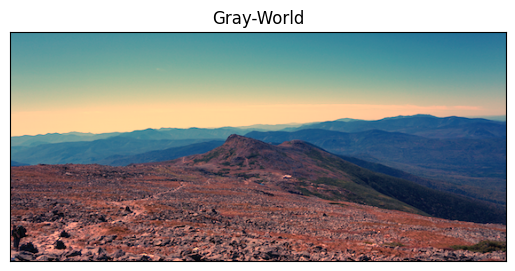

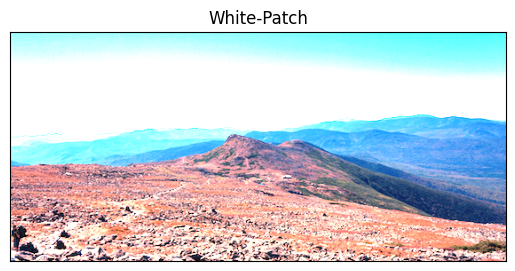

In [14]:
# load image
input_img = plt.imread('./input.png')
# TODO: check img data type


if input_img.shape[2] == 4:
    input_img = input_img[:, :, :3].astype(np.float32)
else:
    input_img = input_img.astype(np.float32)

def gray_world(input_img):
    # TODO: get average green value
    # compute scale factor for red and blue
    # rescale red and blue channels

    # Calculate mean of each color channel
    r_mean = np.mean(input_img[:, :, 0])
    g_mean = np.mean(input_img[:, :, 1])
    b_mean = np.mean(input_img[:, :, 2])

    # Use avg value of green channel as target mean
    target_mean = g_mean

    # Compute scale factors for red and blue channels

    r_scale = target_mean / r_mean
    g_scale = target_mean / g_mean
    b_scale = target_mean / b_mean

    wb_img = np.zeros_like(input_img)
    wb_img[:, :, 0] = input_img[:, :, 0] * r_scale
    wb_img[:, :, 1] = input_img[:, :, 1] * g_scale
    wb_img[:, :, 2] = input_img[:, :, 2] * b_scale

    # Clip values to ensure they are within the displayable range [0, 1]
    wb_img = np.clip(wb_img, 0, 1)

    return wb_img

def white_patch(input_img):
    # TODO: get point(s) from user
    # compute scale factors for each color channel
    # rescale each color channel


    # Based on the input.png image, a bright cloud region could be around (100, 200)
    # region: top-left corner (100, 200), width 50, height 50
    row_start, col_start = 100, 200
    row_end, col_end = row_start + 50, col_start + 50

    # Extract white patch
    white_patch_region = input_img[row_start:row_end, col_start:col_end, :]

    # Calculate avg color of white patch
    r_avg_patch = np.mean(white_patch_region[:, :, 0])
    g_avg_patch = np.mean(white_patch_region[:, :, 1])
    b_avg_patch = np.mean(white_patch_region[:, :, 2])

    # Find max value among the average patch components
    max_avg_patch = max(r_avg_patch, g_avg_patch, b_avg_patch)

    # Compute scale factors for each color channel
    # Scale each channel so that the brightest component in the patch becomes 1.0
    if max_avg_patch == 0:
        r_scale, g_scale, b_scale = 1.0, 1.0, 1.0
    else:
        r_scale = 1.0 / r_avg_patch if r_avg_patch > 0 else 1.0
        g_scale = 1.0 / g_avg_patch if g_avg_patch > 0 else 1.0
        b_scale = 1.0 / b_avg_patch if b_avg_patch > 0 else 1.0


    wb_img = np.zeros_like(input_img)
    wb_img[:, :, 0] = input_img[:, :, 0] * r_scale
    wb_img[:, :, 1] = input_img[:, :, 1] * g_scale
    wb_img[:, :, 2] = input_img[:, :, 2] * b_scale

    # Clip values to ensure they are within the displayable range [0, 1]
    wb_img = np.clip(wb_img, 0, 1)

    return wb_img

gray_world_output = gray_world(input_img)
white_patch_output = white_patch(input_img)

fig1 = plt.figure()
plt.imshow(gray_world_output)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('Gray-World')
plt.show()

fig2 = plt.figure()
plt.imshow(white_patch_output)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.title('White-Patch')
plt.show()

#### Acknowledgments
This assignment is based on an assignment for Computational Aspects of Digital Photography class by Prof. Wojciech Jarosz at Dartmouth College.